# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

This data represents a total of 17 marketing campaigns that were conducted during a time period of a little over 2 years (from May 2008 to November 2010).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, recall_score

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [5]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [7]:
# Here is a list of the columns in the dataset and their datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [9]:
# Let's look at the % of yes and no responses to see if the dataset is balanced or imbalanced.
df['y'].value_counts(normalize = True)

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

These results show that our dataset is imbalanced with only a little over 11% of the rows containing "yes" values.

In [12]:
print("Percent of Null Values by Column")
print(df.isnull().mean()*100)


Percent of Null Values by Column
age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64


The results above show that the dataset does not contain any null values, meaning we do not need to worry about dropping rows or columns or filling them in order to proceed.

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

The business goal of this task is to attempt to predict whether a marketing call to a customer will result in the client subscribing to a term deposit.
In order to accomplish this goal, we will attempt to determine which features of the provided dataset are most relevant and then build a classification model. 

### Problem 4b: Analyzing & Visualizing the Data

Now that I've stated the Business Objective, but before I actually start encoding the data and creating models, I think it is important for me to understand the dataset a bit more beyond just knowing the overall objective as stated above.

To do this I want to understand a little more about the numeric and non-numeric columns, so I plan to generate some summary statistics for both.

I also want to do some initial visualization of the features in the dataset.  This will give me better intuition about whether there are features that are highly correlated with each other, or if there are some obvious connections between specific features and the 2 target classes (Yes/No).

In [18]:
# look at basic statistics on the numeric columns
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [20]:
# look at basic statistics on the object columns
df.describe(include = 'object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


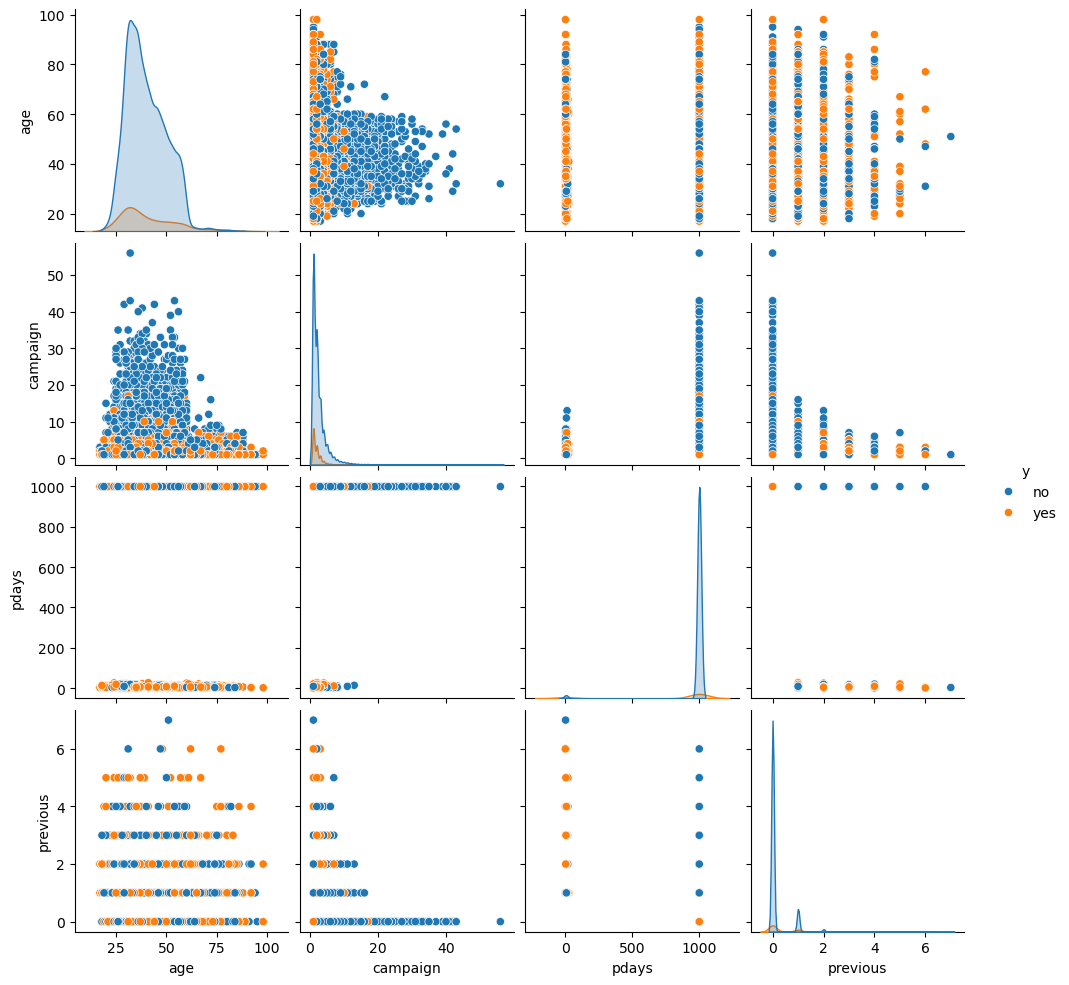

In [22]:
# Now let's add some visualizations to try to determine which features to use for potential models.
data_columns = ['age', 'campaign', 'pdays', 'previous', 'y']
sns.pairplot(df[data_columns], hue = 'y')


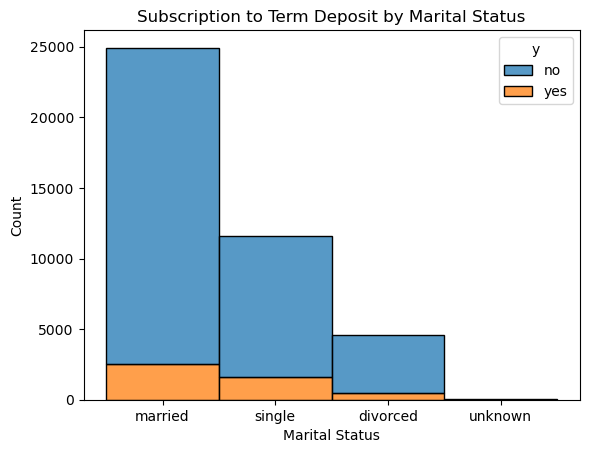

In [24]:
# Let's look at how some of the other features are distributed by the class(target variable).
#sns.countplot(x='marital', hue='y', data=df)
sns.histplot(data=df, x='marital', hue='y', multiple='stack', discrete=True)
plt.title('Subscription to Term Deposit by Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.show()

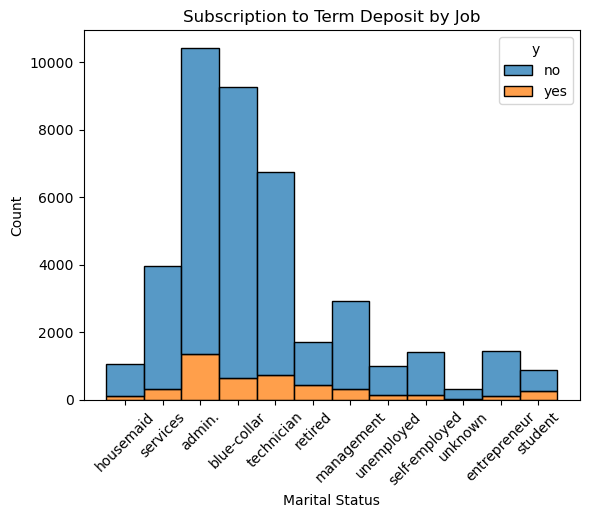

In [26]:
sns.histplot(data=df, x='job', hue='y', multiple='stack', discrete=True)
plt.title('Subscription to Term Deposit by Job')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

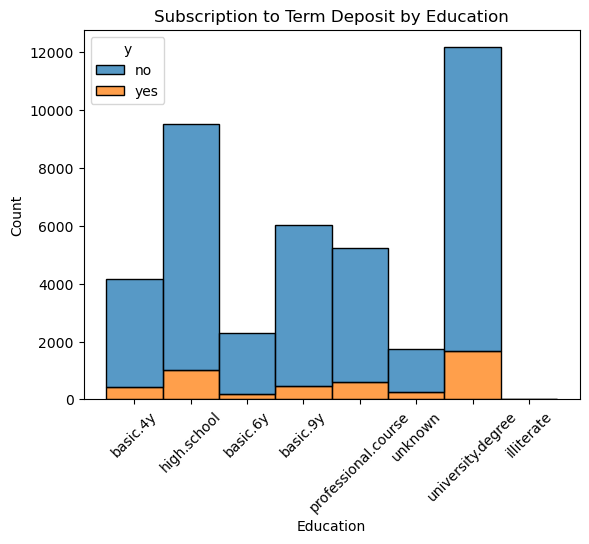

In [28]:
sns.histplot(data=df, x='education', hue='y', multiple='stack', discrete=True)
plt.title('Subscription to Term Deposit by Education')
plt.xlabel('Education')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

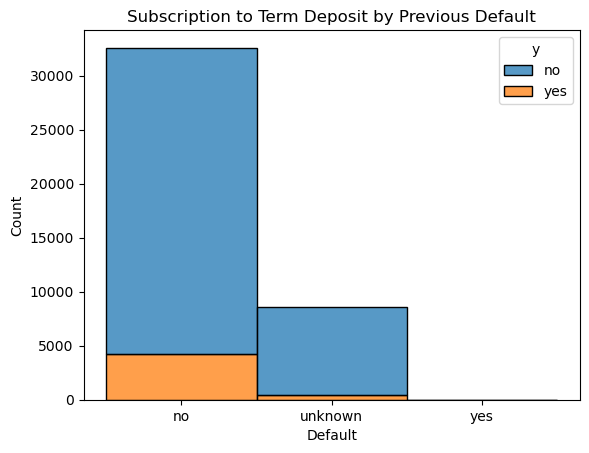

In [30]:
sns.histplot(data=df, x='default', hue='y', multiple='stack', discrete=True)
plt.title('Subscription to Term Deposit by Previous Default')
plt.xlabel('Default')
plt.ylabel('Count')
plt.show()

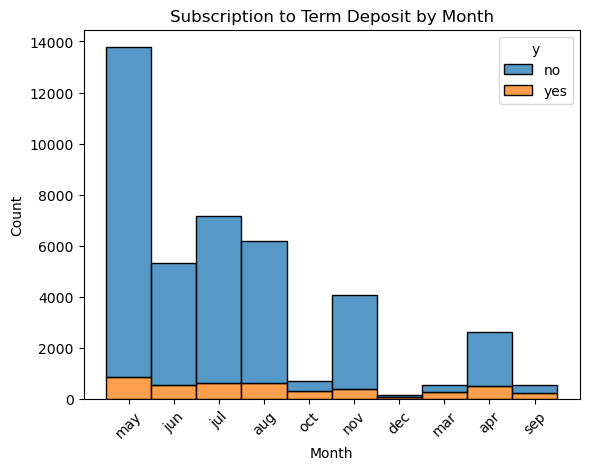

In [32]:
sns.histplot(data=df, x='month', hue='y', multiple='stack', discrete=True)
plt.title('Subscription to Term Deposit by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [34]:
# I also want to examine the correlations between the numeric features.
corr = df.corr(numeric_only = True).round(2)
corr

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp.var.rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons.price.idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons.conf.idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr.employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


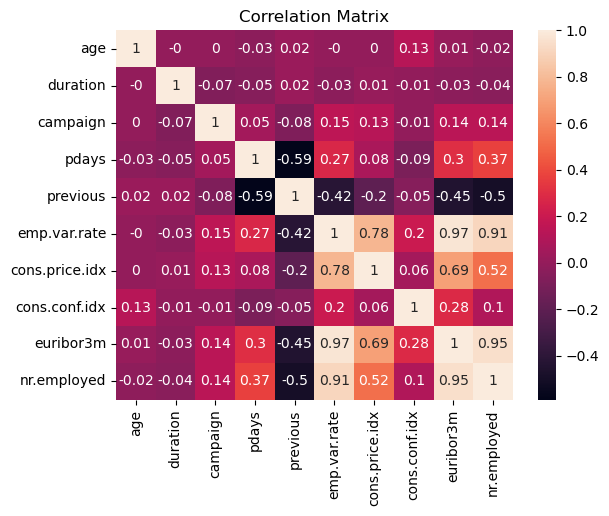

In [36]:
# creating a heatmap to visualize the correlations will be helpful.
sns.heatmap(corr, annot = True);
plt.title('Correlation Matrix')
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [38]:
# I need to start by deciding which features I plan to use for building my models, and also separate the target column.
# To start I am going to focus on the customer and marketing campaign related features, not the various economic indices.
# Many of the economic indices also seem to be highly correlated with each other.
# I am also removing duration - as noted above this information would not be available ahead of the customer marketing call
# so it doesn't belong in a predictive model.

features_list = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 
                 'campaign', 'pdays', 'previous', 'poutcome']
num_features = ['age', 'campaign', 'pdays', 'previous']
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# select feature columns to use.
X = df[features_list]

# select the target column and convert No/Yes to 0/1 values.
y = df['y']
le = LabelEncoder()
y = le.fit_transform(y)



In [42]:
# We also need to encode all of the categorical columns for our models using one hot encoding
X = pd.get_dummies(X, columns=cat_features, drop_first=True, dtype='int64')
X.head()

,age,campaign,pdays,previous,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,1,999,0,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
1,57,1,999,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,37,1,999,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,40,1,999,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,56,1,999,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [44]:
# lets split the data into train and test datasets.  We can keep 30% for the test
X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [46]:
# Creating a results table so that I can track all of the models and compare them at the end.
# The columns will be: model, train_time, train_accuracy, test_accuracy, train_recall, test_recall
results = []

Accuracy on Training Data:  0.887
Accuracy on Test Data:  0.888


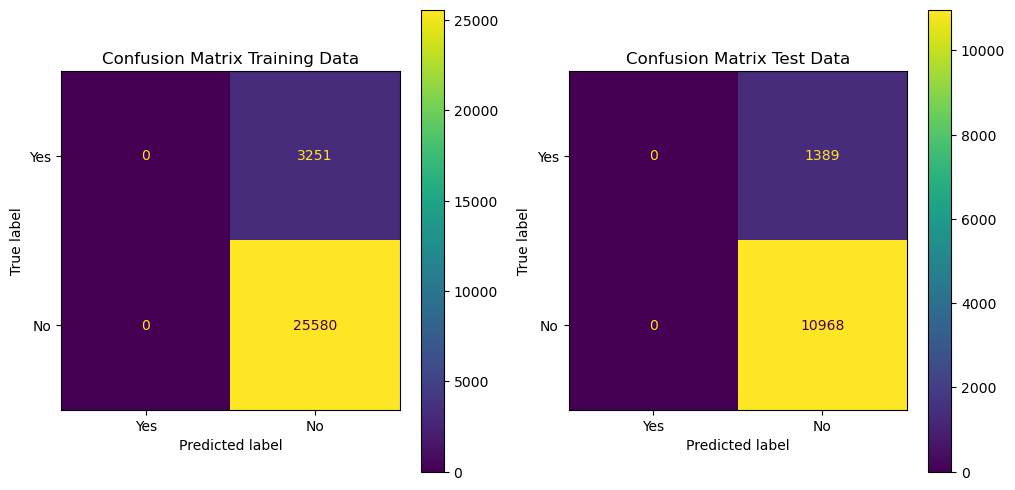

Baseline Model Training Data Recall:  0.0
Baseline Model Test Data Recall:  0.0


In [48]:
# Create a baseline model that predicts the most frequent class
# In the case of our data, this model will just predict 0/no all the time
start_time = time.time()
baseline = DummyClassifier(strategy='most_frequent')
baseline.fit(X_train, y_train)
end_time = time.time()
baseline_model_time = end_time - start_time

y_pred_train = baseline.predict(X_train)
y_pred_test = baseline.predict(X_test)
# We can view the overall accuracy score of this baseline model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Accuracy on Training Data: ", round(acc_train,3))
print("Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
baseline_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=baseline_train_cm, display_labels = ['Yes' ,'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

baseline_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=baseline_test_cm, display_labels = ['Yes' ,'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  baseline_train_cm.ravel()
baseline_train_recall = tp / (tp + fn)
print("Baseline Model Training Data Recall: ", round(baseline_train_recall, 3))

tp, fn, fp, tn =  baseline_test_cm.ravel()
baseline_test_recall = tp / (tp + fn)
print("Baseline Model Test Data Recall: ", round(baseline_test_recall, 3))

#store metrics for this model
results.append(["baseline", baseline_model_time, acc_train, acc_test, baseline_train_recall, baseline_test_recall])

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Basic Logistic Regression Model

In [52]:
# before building this model, I am going to scale the data:
scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_sc = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [54]:
# Here is a basic logistic regression model.
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train_sc, y_train)
end_time = time.time()
lr_model_time = end_time - start_time

print("The Logistic Regression model took ", round(lr_model_time, 4))


The Logistic Regression model took  0.0908


### Problem 9: Score the Model

What is the accuracy of your model?

Logistic Regression Accuracy on Training Data:  0.897
Logistic Regression Accuracy on Test Data:  0.898


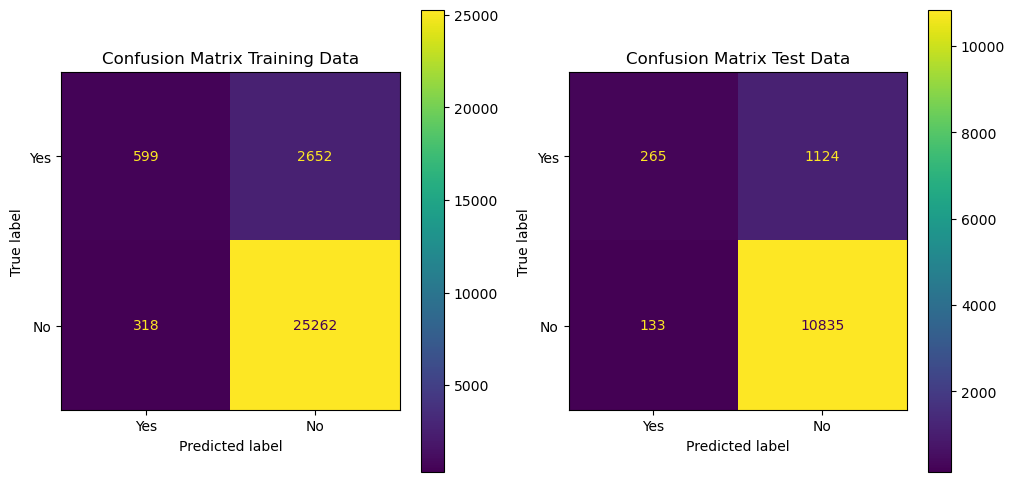

Logistic Regression Training Data Recall:  0.184
Logistic Regression Test Data Recall:  0.191


In [56]:
# Now let's evaluate it:
y_pred_train = lr.predict(X_train_sc)
y_pred_test = lr.predict(X_test_sc)

# We can view the overall accuracy score of this Logistic Regression model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Logistic Regression Accuracy on Training Data: ", round(acc_train, 3))
print("Logistic Regression Accuracy on Test Data: ", round(acc_test, 3))


# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
lr_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=lr_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

lr_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=lr_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')

plt.show()


# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  lr_train_cm.ravel()
lr_train_recall = tp / (tp + fn)
print("Logistic Regression Training Data Recall: ", round(lr_train_recall, 3))


# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  lr_test_cm.ravel()
lr_test_recall = tp / (tp + fn)
print("Logistic Regression Test Data Recall: ", round(lr_test_recall, 3))

#store metrics for this model
results.append(["Logistic Regression", lr_model_time, acc_train, acc_test, lr_train_recall, lr_test_recall])

In summary: The accuracy of this simple model is slightly better than the baseline model.
The recall is also better, but 0.18 and 0.19 are stil very low values.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Basic KNN Model

The KNN model took  0.0136
KNN Accuracy on Training Data:  0.909
KNN Accuracy on Test Data:  0.891


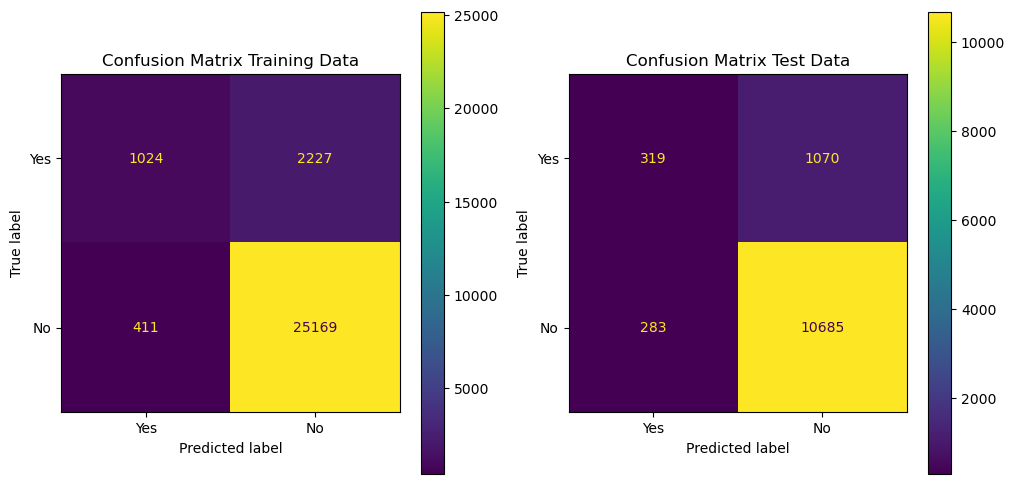

KNN Training Data Recall:  0.315
KNN Test Data Recall:  0.23


In [58]:
# Basic KNN model
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)
end_time = time.time()
knn_model_time = end_time - start_time

print("The KNN model took ", round(knn_model_time, 4))

# Now let's evaluate it:
y_pred_train = knn.predict(X_train_sc)
y_pred_test = knn.predict(X_test_sc)

# We can view the overall accuracy score of this KNN model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("KNN Accuracy on Training Data: ", round(acc_train, 3))
print("KNN Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
knn_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=knn_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

knn_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=knn_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  knn_train_cm.ravel()
knn_train_recall = tp / (tp + fn)
print("KNN Training Data Recall: ", round(knn_train_recall, 3))

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  knn_test_cm.ravel()
knn_test_recall = tp / (tp + fn)
print("KNN Test Data Recall: ", round(knn_test_recall, 3))

#store metrics for this model
results.append(["KNN", knn_model_time, acc_train, acc_test, knn_train_recall, knn_test_recall])

### Basic Decision Tree Model

The Decision Tree model took  0.1407
Decision Tree Accuracy on Training Data:  0.994
Decision Tree Accuracy on Test Data:  0.832


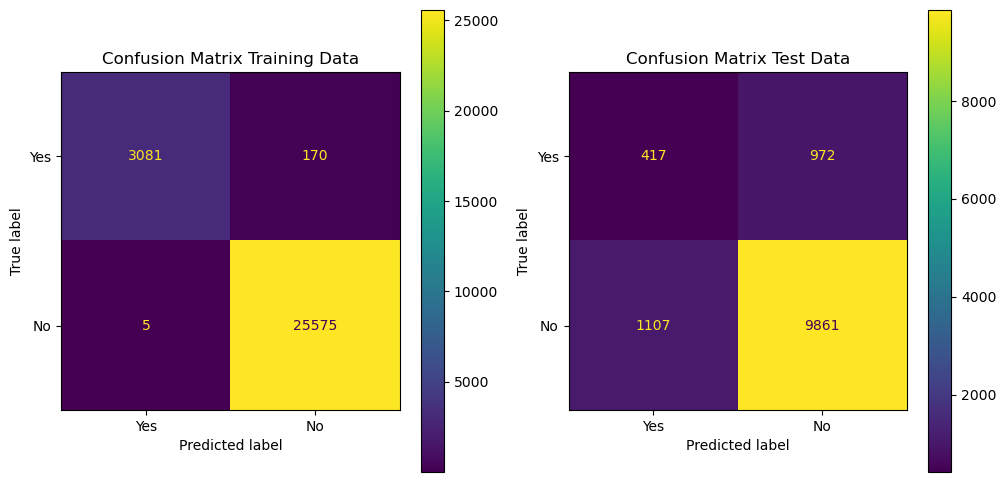

Decision Tree Training Data Recall:  0.948
Decision Tree Test Data Recall:  0.3


In [60]:
# Basic DecisionTree model
# Note that unlike the other models, we can use un-scaled data for Decision Trees
start_time = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
end_time = time.time()
dt_model_time = end_time - start_time

print("The Decision Tree model took ", round(dt_model_time, 4))

# Now let's evaluate it:
y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)

# We can view the overall accuracy score of this Decision Tree model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("Decision Tree Accuracy on Training Data: ", round(acc_train, 3))
print("Decision Tree Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
dt_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=dt_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

dt_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=dt_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  dt_train_cm.ravel()
dt_train_recall = tp / (tp + fn)
print("Decision Tree Training Data Recall: ", round(dt_train_recall, 3))

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  dt_test_cm.ravel()
dt_test_recall = tp / (tp + fn)
print("Decision Tree Test Data Recall: ", round(dt_test_recall, 3))

#store metrics for this model
results.append(["Decision Tree", dt_model_time, acc_train, acc_test, dt_train_recall, dt_test_recall])

### Basic SVM Model

The SVM model took  26.0687
SVM Accuracy on Training Data:  0.907
SVM Accuracy on Test Data:  0.899


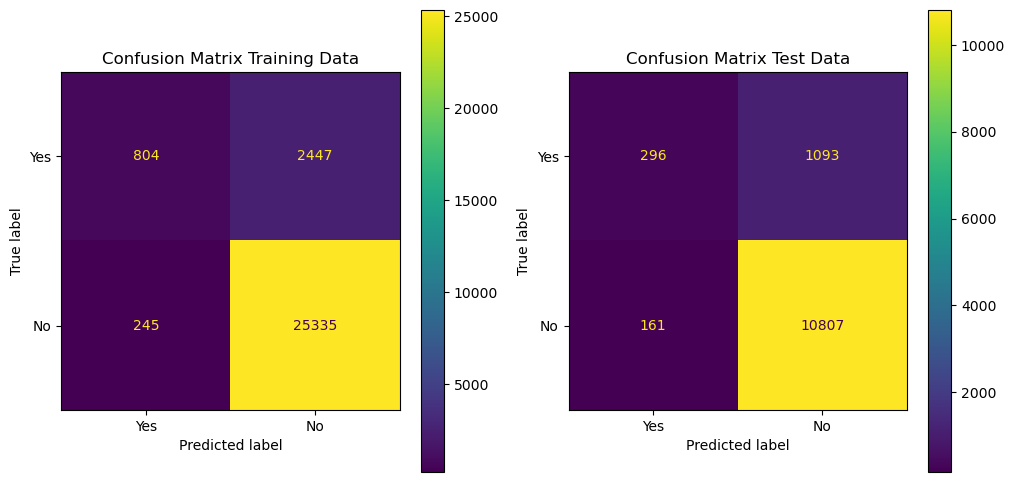

SVM Training Data Recall:  0.247
SVM Test Data Recall:  0.213


In [62]:
# Basic SVM model
start_time = time.time()
svm = SVC()
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time

print("The SVM model took ", round(svm_model_time, 4))

# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)
print("SVM Accuracy on Training Data: ", round(acc_train, 3))
print("SVM Accuracy on Test Data: ", round(acc_test, 3))

# Set up the matplotlib figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# here is the confusion matrix, which is probably a better way to assess these models, particularly given the imbalanced data.
svm_train_cm = confusion_matrix(y_train, y_pred_train, labels = [1, 0])
disp1 = ConfusionMatrixDisplay(confusion_matrix=svm_train_cm, display_labels = ['Yes', 'No'])
disp1.plot(ax=axes[0])
axes[0].set_title('Confusion Matrix Training Data')

svm_test_cm = confusion_matrix(y_test, y_pred_test, labels = [1, 0])
disp2 = ConfusionMatrixDisplay(confusion_matrix=svm_test_cm, display_labels = ['Yes', 'No'])
disp2.plot(ax=axes[1])
axes[1].set_title('Confusion Matrix Test Data')
plt.show()

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  svm_train_cm.ravel()
svm_train_recall = tp / (tp + fn)
print("SVM Training Data Recall: ", round(svm_train_recall, 3))

# in particular we want to look at recall because we care about missing calls to people who will say "yes"
tp, fn, fp, tn =  svm_test_cm.ravel()
svm_test_recall = tp / (tp + fn)
print("SVM Test Data Recall: ", round(svm_test_recall, 3))

#store metrics for this model
results.append(["SVM", svm_model_time, acc_train, acc_test, svm_train_recall, svm_test_recall])

In [64]:
# Overall results from the models we've created so far

# Create a DataFrame with the results from the models
results_df = pd.DataFrame(results, columns=['model', 'model time', 'train acc', 'test acc', 'train recall', 'test recall'])
results_df

,model,model time,train acc,test acc,train recall,test recall
0,baseline,0.003252,0.887239,0.887594,0.000000,0.000000
1,Logistic Regression,0.090796,0.896986,0.898276,0.184251,0.190785
2,KNN,0.013582,0.908501,0.890507,0.314980,0.229662
3,Decision Tree,0.140659,0.993930,0.831755,0.947708,0.300216
4,SVM,26.068715,0.906628,0.898519,0.247309,0.213103


Most of these have better accuracy and all have better recall than the baseline Dummy model.  Decision Tree did the best on recall but the large difference between training and test results suggest this model is overfit.
The KNN model did second best, and SVM has similar recall results.  Of all of these models, Logistic Regression is the weakest on recall.
But none of these recall percentages are great.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [66]:
# Let's use GridSearchCV to try different options for these models
# I've removed SVM from this list because it was too slow to incorporate in the GridSearchCV - it needs more time/computing power.

models = {
    'KNN': (KNeighborsClassifier(), {'KNN__n_neighbors': [3, 5, 7]}),
    'LogisticRegression': (LogisticRegression(max_iter=1000), {'LogisticRegression__C': [0.1, 1, 10]}),
    'DecisionTree': (DecisionTreeClassifier(), {'DecisionTree__max_depth': [5, 10, 15, 20, 25, 30]})
}

gs_results = []

for name, (model, params) in models.items():
    
    # Create a pipeline
    pipeline = Pipeline([
        (name, model)
    ])
    
    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1, scoring = 'recall')
    
    # Fit the model and time it
    start_time = time.time()
    if name == 'DecisionTree':
        grid_search.fit(X_train, y_train)
    else:
        grid_search.fit(X_train_sc, y_train)        
    model_time = (time.time() - start_time) / len(grid_search.cv_results_['mean_fit_time'])
    
    # Get the best estimator
    best_model = grid_search.best_estimator_

    # Predict using the best model
    if name == 'DecisionTree':
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
    else: 
        y_pred_train = best_model.predict(X_train_sc)
        y_pred_test = best_model.predict(X_test_sc)
       
    
    # Evaluate on training and test sets
    if name == 'DecisionTree':
        acc_train_score = best_model.score(X_train, y_train)
        acc_test_score = best_model.score(X_test, y_test)
    else:
        acc_train_score = best_model.score(X_train_sc, y_train)
        acc_test_score = best_model.score(X_test_sc, y_test)
    
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    
    # Append the results
    gs_results.append([name, best_model, model_time, acc_train_score, acc_test_score, recall_train, recall_test])

# Create the results DataFrame
gs_results_df = pd.DataFrame(gs_results, columns=['model', 'optimal model', 'model time', 'train acc', 'test acc', 'train recall', 'test recall'])
gs_results_df





,model,optimal model,model time,train acc,test acc,train recall,test recall
0,KNN,(KNeighborsClassifier(n_neighbors=3)),1.202515,0.919913,0.879016,0.430944,0.242621
1,LogisticRegression,"(LogisticRegression(C=1, max_iter=1000))",0.096423,0.896986,0.898276,0.184251,0.190785
2,DecisionTree,(DecisionTreeClassifier(max_depth=30)),0.183682,0.982796,0.842761,0.851738,0.289417


The Decision Tree has the highest training and test recall. However, there is a big difference between training and test results for this model, suggesting that there is a still a bunch of overfitting happening here.

In [68]:
# Since GridSearchCV is taking too long for the SVM models, I am going to try creating and comparing a few versions here.
svm_results = []

# this one has a linear kernel and a C-value of 0.1
start_time = time.time()
svm = SVC(kernel = 'linear', C = 0.1)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-linear-C=0.1", svm_model_time, acc_train, acc_test, recall_train, recall_test])



In [75]:
# This one has a linear kernel and a C value of 1.0
start_time = time.time()
svm = SVC(kernel = 'linear', C = 1.0)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-linear-C=1.0", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [77]:
# this one has a rbf kernel and a C-value of 0.1
start_time = time.time()
svm = SVC(kernel = 'rbf', C = 0.1)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-rbf-C=0.1", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [79]:
# this one has a rbf kernel and a C-value of 1.0
start_time = time.time()
svm = SVC(kernel = 'rbf', C = 1.0)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-rbf-C=1.0", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [81]:
# this one has a rbf kernel and a C-value of 10.0
start_time = time.time()
svm = SVC(kernel = 'rbf', C = 10.0)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-rbf-C=10.0", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [83]:
# this one has a poly kernel and a C-value of 1.0
start_time = time.time()
svm = SVC(kernel = 'poly', C = 1.0)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-poly-C=1.0", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [85]:
# this one has a poly kernel and a C-value of 10.0
start_time = time.time()
svm = SVC(kernel = 'poly', C = 10.0)
svm.fit(X_train_sc, y_train)
end_time = time.time()
svm_model_time = end_time - start_time
# Now let's evaluate it:
y_pred_train = svm.predict(X_train_sc)
y_pred_test = svm.predict(X_test_sc)

# We can view the overall accuracy score of this SVM model on the training & test data
acc_train = accuracy_score(y_train, y_pred_train)
acc_test = accuracy_score(y_test, y_pred_test)

#Let's also look at the recall score
recall_train = recall_score(y_train, y_pred_train)
recall_test = recall_score(y_test, y_pred_test)

#store metrics for this model
svm_results.append(["SVM-poly-C=10.0", svm_model_time, acc_train, acc_test, recall_train, recall_test])

In [87]:
# Create the results DataFrame
svm_results_df = pd.DataFrame(svm_results, columns=['model', 'model time', 'train acc', 'test acc', 'train recall', 'test recall'])
svm_results_df


,model,model time,train acc,test acc,train recall,test recall
0,SVM-linear-C=0.1,43.991779,0.897818,0.896820,0.206706,0.212383
1,SVM-linear-C=1.0,475.086107,0.897818,0.896820,0.206706,0.212383
2,SVM-rbf-C=0.1,14.701678,0.897610,0.896172,0.173793,0.171346
3,SVM-rbf-C=1.0,26.070917,0.906628,0.898519,0.247309,0.213103
4,SVM-rbf-C=10.0,36.289658,0.928376,0.895039,0.395571,0.228942
5,SVM-poly-C=1.0,30.011037,0.916271,0.895363,0.313134,0.219582
6,SVM-poly-C=10.0,84.140299,0.930387,0.889617,0.416487,0.228942


Overall Summary:
Although the analysis of the models includes accuracy scores, I also focused on recall score given the imbalance of the target variable.
I selected recall because it seemed more important for this business problem to correctly identify as many of the "Yes' values as possible so as not to miss customers that would subscribe to a term deposit.
All of the models (Logistic Regression, KNN, Decision Trees and SVM) did better than the Baseline Dummy model on the Recall score.
Decision Trees had the highest recall scores on training and test data, but the huge discrepancies between their training and test scores suggest that they may be overfit. 
KNN and SVM models did a bit better than the Logistic Regression models on recall.
However, none of these models have great test recall scores (Decision Trees have the highest but it is only about 30%).
This suggests a need to continue trying to improve the model, either by further tuning, finding better models than the ones included here, or gathering additional data that might create improved predictions.


##### Questions